In [1]:
!pip install transformers tensorflow datasets kaggle


[notice] A new release of pip available: 22.2.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
!if [ ! -e ~/.kaggle/kaggle.json ]; then mkdir -p ~/.kaggle; mv ~/kaggle.json ~/.kaggle; echo "Copied"; fi
!chmod 600 ~/.kaggle/kaggle.json
!ls -alR ~/.kaggle

/opt/app-root/src/.kaggle:
total 12
drwxrwsr-x.  2 1006090000 1006090000 4096 Oct  5 08:28 .
drwxrwsr-x. 14 root       1006090000 4096 Oct  6 10:42 ..
-rw-------.  1 1006090000 1006090000   69 Oct  5 08:28 kaggle.json


In [3]:
# Create directory to save results
!mkdir -p models

# https://nihcc.app.box.com/v/ChestXray-NIHCC

#kaggle datasets list
!rm -rf chest_xray
!kaggle datasets download paultimothymooney/chest-xray-pneumonia
!if [ ! -d chest_xray.dataset ]; then unzip -q chest-xray-pneumonia.zip; mv chest_xray chest_xray.dataset; fi
!rm -rf chest_xray.dataset/__MACOSX
!echo "Download complete"

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)
Download complete


In [4]:
import tensorflow as tf
#from sklearn.model_selection import train_test_split

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

2024-10-07 02:50:40.212863: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-07 02:50:40.212945: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-07 02:50:40.214421: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-07 02:50:40.222394: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-07 02:50:41.282630: W tensorflow/comp

Number of replicas: 1
2.15.1


In [44]:
import pandas

def tuple_prefix(tpl, element):
    lst = list(tpl)
    lst.insert(0, element)
    return tuple(lst)

def tuple_append(tpl, element):
    lst = list(tpl)
    lst.append(element)
    return tuple(lst)

def show_image(filename):
    img = matplotlib.image.imread(filename)
    matplotlib.pyplot.imshow(img)
    matplotlib.pyplot.show()    

# Plot model training performance    
def plot_history(hist):
    print(hist.params)
    df = pandas.DataFrame(data=hist.history, columns=hist.history.keys())
    df.plot(figsize=(5, 5))

    matplotlib.pyplot.title('Baseline Performance')
    matplotlib.pyplot.xlabel('Epoch')
    matplotlib.pyplot.ylabel('Metric')

    # pyplot requires all rows to have the same number of keys
    matplotlib.pyplot.show()

def create_generator(path, input_size, batch_size, training=False):
    # ImageDataGenerator rescales the pixels between zero and one

    # Set augmentation for testing
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)

    if training:
        # Configure augmentation for training adversity
        datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1.0/255,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True)

    return datagen.flow_from_directory(
        path,  
        target_size=input_size,
        batch_size=batch_size,  # Batch size defines the number of samples that will be propagated through the network
        class_mode='binary',        
        color_mode='rgb',
        interpolation="nearest",
        keep_aspect_ratio=False)


In [6]:

INPUT_SIZE = (228,228) # use the same pixel h * w target size for all images processed
MODEL_INPUT_SHAPE = tuple_append(INPUT_SIZE, 3)
MODEL_FEATURE_SHAPE = (7,7,512)
MODEL_FEATURE_LEN = MODEL_FEATURE_SHAPE[0]*MODEL_FEATURE_SHAPE[1]*MODEL_FEATURE_SHAPE[2]

models = {}

models['vgg_base'] = tf.keras.applications.VGG19(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=MODEL_INPUT_SHAPE,
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)

print('VGG19 Loaded')
print(models['vgg_base'].summary())

VGG19 Loaded
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 228, 228, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 228, 228, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 228, 228, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 114, 114, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 114, 114, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 114, 114, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 57, 57, 128)

In [7]:
# Get model to output 3D feature maps (height, width, features)
models['pneu1'] = tf.keras.models.Sequential()

# Layer 1
models['pneu1'].add(tf.keras.layers.Conv2D(32, (3, 3), input_shape=MODEL_INPUT_SHAPE))
models['pneu1'].add(tf.keras.layers.Activation('relu'))
models['pneu1'].add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Layer 2
models['pneu1'].add(tf.keras.layers.Conv2D(32, (3, 3)))
models['pneu1'].add(tf.keras.layers.Activation('relu'))
models['pneu1'].add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Layer 3
models['pneu1'].add(tf.keras.layers.Conv2D(64, (3, 3)))
models['pneu1'].add(tf.keras.layers.Activation('relu'))
models['pneu1'].add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Apply flattening function to convert 3D feature maps in to 1D feature vectors
models['pneu1'].add(tf.keras.layers.Flatten())  

# Add 2 final dense layers to add a classifier to the convolutional base
models['pneu1'].add(tf.keras.layers.Dense(64))
models['pneu1'].add(tf.keras.layers.Activation('relu'))
models['pneu1'].add(tf.keras.layers.Dropout(0.5))
models['pneu1'].add(tf.keras.layers.Dense(1))
models['pneu1'].add(tf.keras.layers.Activation('sigmoid'))

# Compile the model
models['pneu1'].compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Print model summary
print(models['pneu1'].summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 226, 226, 32)      896       
                                                                 
 activation (Activation)     (None, 226, 226, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 113, 113, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 111, 111, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 111, 111, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 55, 55, 32)        0         
 g2D)                                                   

Processing chest_xray.dataset/val...
Listing chest_xray.dataset/val/NORMAL
Sample NORMAL2-IM-1430-0001.jpeg


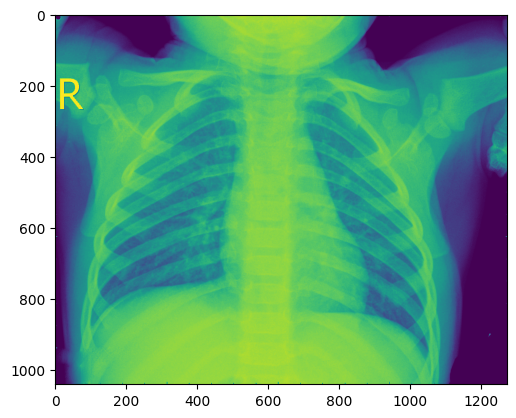

Listing chest_xray.dataset/val/PNEUMONIA
Sample person1946_bacteria_4874.jpeg


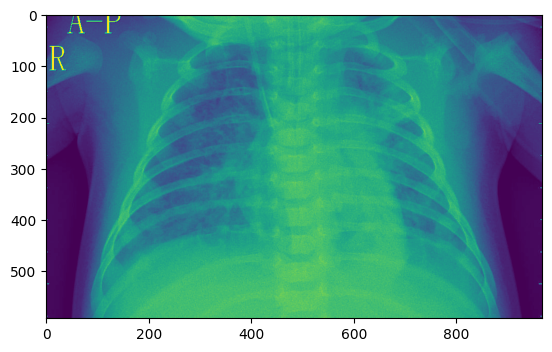

Processing chest_xray.dataset/train...
Listing chest_xray.dataset/train/NORMAL
Sample NORMAL2-IM-1179-0001.jpeg


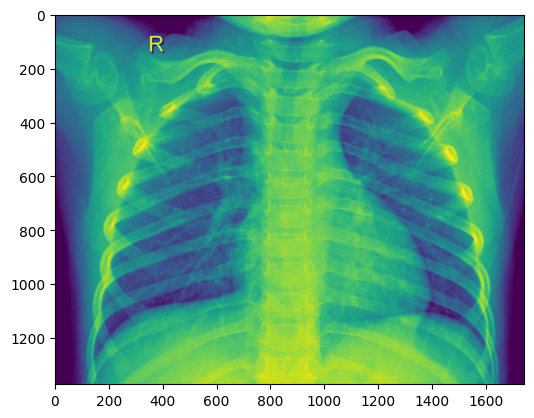

Listing chest_xray.dataset/train/PNEUMONIA
Sample person736_virus_1358.jpeg


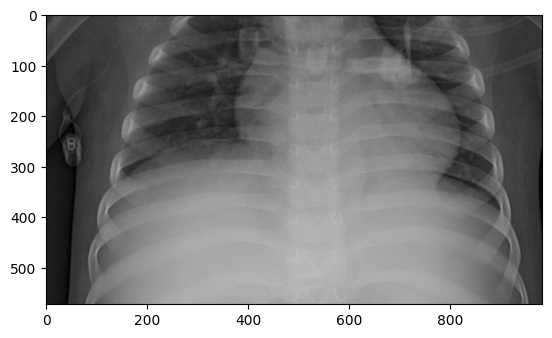

Processing chest_xray.dataset/test...
Listing chest_xray.dataset/test/NORMAL
Sample NORMAL2-IM-0206-0001.jpeg


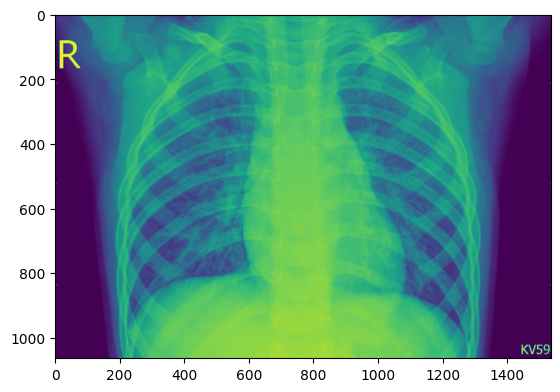

Listing chest_xray.dataset/test/PNEUMONIA
Sample person126_bacteria_598.jpeg


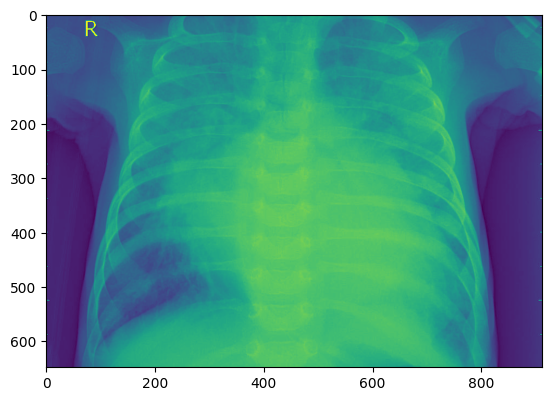

1500
50 30 5216
Training set size is too small
Train size: 5216, New epoch size: 20, New batch size: 23
Processing 16 files in chest_xray.dataset/val...
Found 16 images belonging to 2 classes.
Processing 5216 files in chest_xray.dataset/train...
Found 5216 images belonging to 2 classes.
Processing 624 files in chest_xray.dataset/test...
Found 624 images belonging to 2 classes.
Complete


In [43]:
import os, matplotlib, numpy, math
import matplotlib.image, matplotlib.pyplot

# Specify dataset size
VALIDATION_SPLIT=0.1
DEFAULT_BATCH_SIZE = 50
DEFAULT_EPOCHS = 30
COLOR_MODE='rgb' # grayscale

# Specify reference for directory paths
dataset_root = "chest_xray.dataset"
classifications = [ "NORMAL", "PNEUMONIA" ]
folders = [ "val", "train", "test" ]

#def preprocess_data(examples):
def dataset_size(directory, labels, showSample=False):
    size = 0 
    for label in labels:
        path = "{}/{}".format(directory, label)
        print("Listing {}".format(path))
        contents = os.listdir(path)
        size += len(contents)
        if showSample:
            for pic_file in  numpy.random.choice(contents, 1):
                print("Sample {}".format(pic_file))
                show_image("{}/{}".format(path,pic_file))
    return size    

def extract_features(directory, sample_amount, batch_size=0):
    if batch_size < 1:
        batch_size = DEFAULT_BATCH_SIZE
    
    features = numpy.zeros(shape=tuple_prefix(MODEL_FEATURE_SHAPE, sample_amount)) 
    labels = numpy.zeros(shape=(sample_amount))
    generator = create_generator(directory, INPUT_SIZE, batch_size)

    i = 0
    for inputs_batch, labels_batch in generator:
        #print("Inputs: {}".format(inputs_batch))
        #print("Labels: {}".format(labels_batch))
        features_batch = models['vgg_base'].predict(inputs_batch, verbose=0)
        features[i * batch_size : (i + 1) * batch_size] = features_batch 
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i = i + 1
        if i * batch_size >= sample_amount:
            break
    return features, labels


dataset = {}

# Apply extraction function to 3 datasets
for folder in folders:
    dataset[folder] = {}
    path = "{}/{}".format(dataset_root, folder)
    print("Processing {}...".format(path))
    num_samples = dataset_size(path, classifications, True)
    #num_samples = min(1000, num_samples)
    dataset[folder]['size'] = num_samples

    
def nice_epochs(samples, split):
    calc = int(math.sqrt(samples * (1-split) / 10))
    remainder = calc % 5
    return min(30, calc - remainder)

def nice_batch(samples, split, epochs):
    return int(samples * (1-VALIDATION_SPLIT) / epochs / 10)

#print(nice_batch(500100, 0.1, 30))
#print(DEFAULT_BATCH_SIZE, DEFAULT_EPOCHS, dataset['train']['size'])
if DEFAULT_BATCH_SIZE * DEFAULT_EPOCHS * 10 > dataset['train']['size'] * (1-VALIDATION_SPLIT): 
    print("Training set size is too small")
    DEFAULT_EPOCHS = nice_epochs(dataset['train']['size'], VALIDATION_SPLIT)
    DEFAULT_BATCH_SIZE = nice_batch(dataset['train']['size'], VALIDATION_SPLIT, DEFAULT_EPOCHS)
    print('Train size: {}, New epoch size: {}, New batch size: {}'.format(dataset['train']['size'], DEFAULT_EPOCHS, DEFAULT_BATCH_SIZE))
    print()
    #raise Exception("stop")
    
for folder in folders:
    path = "{}/{}".format(dataset_root, folder)
    print("Processing {} files in {}...".format(dataset[folder]['size'], path))
    features, labels = extract_features(path, dataset[folder]['size'])
    dataset[folder]['features'] = features
    dataset[folder]['labels'] = labels
    
print("Complete")


In [48]:
# Shape data
for folder in folders:
    print("Reprocessing {}...".format(folder))
    dataset[folder]['features'] = numpy.reshape(dataset[folder]['features'], (dataset[folder]['size'], MODEL_FEATURE_LEN))

print("Complete")

Reprocessing val...
Reprocessing train...
Reprocessing test...
Complete


In [50]:
generators = {}
for folder in folders:
    # Read pictures in 'data/train' directory and generate batches of image data with binary labels
    path = "{}/{}".format(dataset_root, folder)
    print("Processing {}...".format(path))
    generators[folder] = create_generator(path, INPUT_SIZE, DEFAULT_BATCH_SIZE, True)

print("Complete")

Processing chest_xray.dataset/val...
Found 16 images belonging to 2 classes.
Processing chest_xray.dataset/train...
Found 5216 images belonging to 2 classes.
Processing chest_xray.dataset/test...
Found 624 images belonging to 2 classes.
Complete


5216 16 326 16.0
Epoch 1/20
226/226 [==============================] - 163s 718ms/step - loss: 0.5042 - accuracy: 0.7747 - val_loss: 0.8694 - val_accuracy: 0.6875
Epoch 2/20
226/226 [==============================] - 165s 727ms/step - loss: 0.3055 - accuracy: 0.8677 - val_loss: 3.0835 - val_accuracy: 0.5625
Epoch 3/20
226/226 [==============================] - 163s 719ms/step - loss: 0.2611 - accuracy: 0.8956 - val_loss: 1.2545 - val_accuracy: 0.7500
Epoch 4/20
226/226 [==============================] - 161s 710ms/step - loss: 0.2416 - accuracy: 0.9101 - val_loss: 1.1775 - val_accuracy: 0.7500
Epoch 5/20
226/226 [==============================] - 161s 712ms/step - loss: 0.2165 - accuracy: 0.9197 - val_loss: 1.1170 - val_accuracy: 0.7500
Epoch 6/20
226/226 [==============================] - 161s 713ms/step - loss: 0.2083 - accuracy: 0.9282 - val_loss: 1.7078 - val_accuracy: 0.6875
Epoch 7/20
226/226 [==============================] - 161s 713ms/step - loss: 0.1872 - accuracy: 0.9293 - v

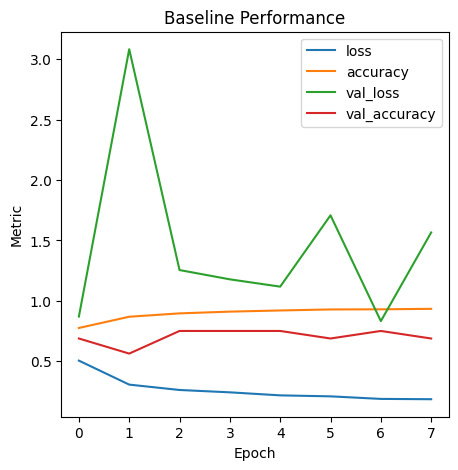

In [56]:
# Set stop to 5 epochs
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    restore_best_weights=True,
    patience=5
)

val_batch_size = min(DEFAULT_BATCH_SIZE, dataset['val']['size'])
print(dataset['train']['size'], batch_size, dataset['train']['size'] // batch_size, dataset['train']['size'] / DEFAULT_EPOCHS // batch_size)

# Save weights after implemeting callback to later compare
# Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 9780 batches). 
# You may need to use the repeat() function when building your dataset.
#
# Do not specify the batch_size if your data is in the form of datasets, generators, or keras.utils.PyDataset instances (since they generate batches).
history = models['pneu1'].fit(
        generators['train'],
        steps_per_epoch=dataset['train']['size'] // DEFAULT_BATCH_SIZE,
        epochs=DEFAULT_EPOCHS, # num of epochs will dictate speed of model
        #validation_split=0.1,
        # Or a predefined validation set
        validation_data=generators['val'],
        validation_steps=dataset['val']['size'] // val_batch_size, # Getting this wrong may result in missing val_* readings
        callbacks=[callback]
)
models['pneu1'].save('models/model_pneu1.keras')
print("Complete")

plot_history(history)

In [57]:
print("Evaluate on test data")
results = models['pneu1'].evaluate(generators['test'], batch_size=DEFAULT_BATCH_SIZE)
print("test loss, test acc:", results)

Evaluate on test data
28/28 [==============================] - 12s 409ms/step - loss: 0.5871 - accuracy: 0.8013
test loss, test acc: [0.5871298313140869, 0.8012820482254028]


(1, 228, 228, 3)
1/1 [==============================] - 0s 70ms/step
PNEUMONIA 


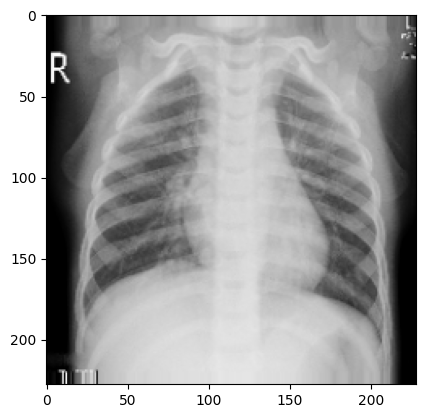


(1, 228, 228, 3)
1/1 [==============================] - 0s 21ms/step
PNEUMONIA - INCORRECT! Predicted 0.9750241041183472, expected 0.0


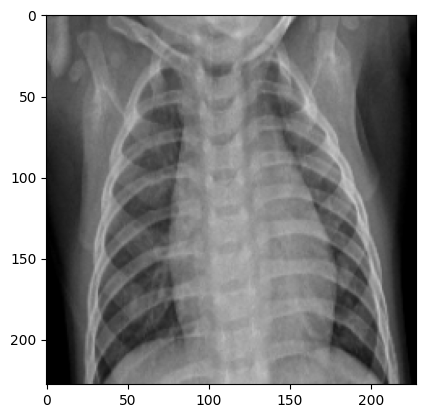


(1, 228, 228, 3)
1/1 [==============================] - 0s 21ms/step
PNEUMONIA - INCORRECT! Predicted 0.9683789014816284, expected 0.0


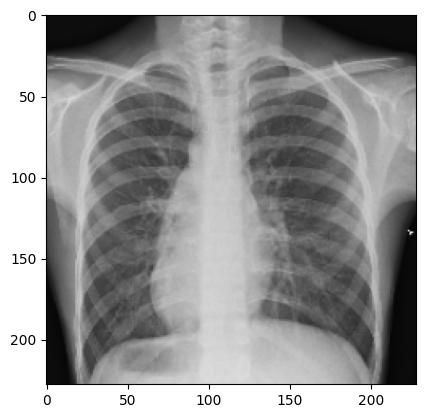


(1, 228, 228, 3)
1/1 [==============================] - 0s 21ms/step
PNEUMONIA 


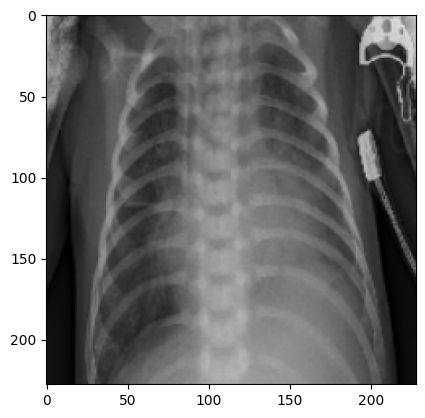


(1, 228, 228, 3)
1/1 [==============================] - 0s 20ms/step
PNEUMONIA 


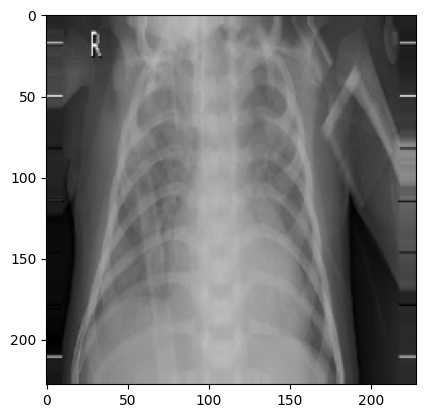

In [58]:
# Validation generator with batch size = 1 

generators['test'].batch_size = 1

# Preview examples from validation set and labels predicted from baseline model
for _ in range(5):
    gn = next(generators['test'])
    x = gn[0]
    print(x.shape)
    px = models['pneu1'].predict(x)
    result = ''
    if px[0][0] > 0.6:
        if gn[1] != 1.0:
            result = '- INCORRECT! Predicted {}, expected {}'.format(px[0][0],gn[1][0])
        print('PNEUMONIA {}'.format(result))
    elif px[0][0] < 0.4:
        if gn[1] != 0.0:
            result = '- INCORRECT! Predicted {}, expected {}'.format(px[0][0],gn[1][0])
        print('NORMAL {}'.format(result))
    else:
        print('UNDECIDED')
        
        

    matplotlib.pyplot.imshow(x.reshape(MODEL_INPUT_SHAPE))
    matplotlib.pyplot.show()
    print()

In [59]:
import random
images = []

count = 5
filter="NORMAL"
while (count > 0):
    filepath = generators['test'].filenames[random.randrange(dataset['test']['size'])]
    if filter in filepath:
        images.append("{}/{}/{}".format(dataset_root, 'test', filepath))
        count -= 1

for image_path in images:
    img = tf.keras.preprocessing.image.load_img(
        image_path, 
        target_size=INPUT_SIZE,
        color_mode=COLOR_MODE,
        interpolation="nearest",
        keep_aspect_ratio=False)  # this is a PIL image
    x = tf.keras.preprocessing.image.img_to_array(img, data_format=generators['test'].data_format)  # this is a Numpy array with shape (3, 150, 150)
    #print(x.shape)
    
    # For consistency with the generators
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)
    xs = datagen.standardize(numpy.copy(x))

    # Predict expects a an array of images
    xr = tf.expand_dims(xs, axis=0)
    #print(xr.shape)

    px = models['pneu1'].predict(xr)
    result = 'UNDECIDED'
    if px[0][0] > 0.6:
        result = 'PNEUMONIA'
    elif px[0][0] < 0.4:
        result = 'NORMAL'
        
    print('{} - Predicted {} for {}'.format(result, px[0][0],image_path))


NameError: name 'test_datagen' is not defined

In [ ]:
# Build classifier on top of  VGG19 <--- but it doesn't!
models['pneu2'] = tf.keras.models.Sequential()

models['pneu2'].add(tf.keras.layers.Conv2D(32, (3, 3), input_shape=MODEL_INPUT_SHAPE))

# Add dense layers on top of VGG19 
# 1
#models['pneu2'].add(tf.keras.layers.Dense(256, activation='relu', input_dim=7 * 7 * 512))
models['pneu2'].add(tf.keras.layers.Dense(256, activation='relu'))
# 2
models['pneu2'].add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Compile
models['pneu2'].compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = models['pneu2'].fit(dataset['train']['features'], dataset['train']['labels'],
                    steps_per_epoch=dataset['train']['size'] / DEFAULT_EPOCHS // batch_size,
                    epochs=DEFAULT_EPOCHS,
                    batch_size=DEFAULT_BATCH_SIZE,
                    validation_data=(dataset['val']['features'], dataset['val']['labels']))



# Save VGG19 results
models['pneu2'].save('models/model_pneu2.keras')

print('Complete')

In [ ]:
plot_history(history)

In [ ]:
print("Evaluate on test data")
results = models['pneu2'].evaluate(generators['test'], batch_size=DEFAULT_BATCH_SIZE)
print("test loss, test acc:", results)